<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Sarima Rossmann Lab

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Load the data

In [3]:
df = pd.read_csv('../../../../resource-datasets/rossmann_stores/rossmann.csv')
# Set the DateTime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

/Users/crahmede/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
df.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

## Subset the data on `Store==1` and `Open==1`

The time series we want to predict is the `Sales` column.
Plot the time series.

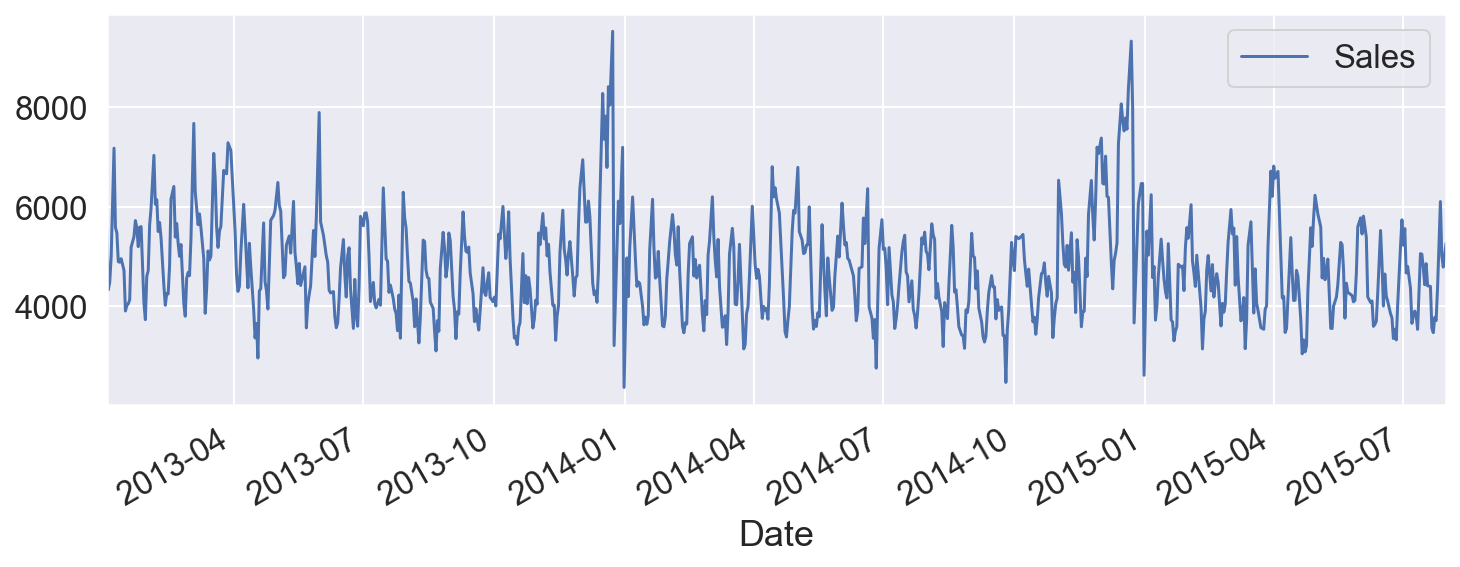

In [5]:
# Filter to Store 1
store1_data = df[df.Store == 1]

# Filter to open days
data = store1_data[store1_data.Open == 1].sort_values(by='Date')

# Plot sales for Store 1 (all days) over time
data[['Sales']].plot(figsize=(12, 4))
plt.show()

In [6]:
# obtain custom datetime index frequency taking into account business days Monday to Saturday
# serves for having index with defined frequency for later plotting
start = data.index.min()
end = data.index.max()
weekmask = 'Mon Tue Wed Thu Fri Sat'
new_index = pd.bdate_range(start=start, end=end, freq='C', weekmask=weekmask)

In [7]:
new_index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-12',
               ...
               '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24',
               '2015-07-25', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', length=807, freq='C')

In [8]:
# there are too many days
new_index.shape

(807,)

In [9]:
data.shape

(781, 8)

In [10]:
# check which days are too much
# turns out these are holidays in Germany (in the state of store 1)
merged = pd.merge(data[['Sales']], pd.DataFrame(list(range(len(
    new_index))), index=new_index), left_index=True, right_index=True, how='outer')
holidays = merged[merged.Sales.isna()].index
holidays

DatetimeIndex(['2013-03-29', '2013-04-01', '2013-05-01', '2013-05-09',
               '2013-05-20', '2013-05-30', '2013-10-03', '2013-12-25',
               '2013-12-26', '2014-01-01', '2014-04-18', '2014-04-21',
               '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19',
               '2014-10-03', '2014-12-25', '2014-12-26', '2015-01-01',
               '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14',
               '2015-05-25', '2015-06-04'],
              dtype='datetime64[ns]', freq=None)

In [11]:
# now take business days and holidays into account
new_index = pd.bdate_range(
    start=start, end=end, freq='C', weekmask=weekmask, holidays=holidays)
data.index = new_index

In [12]:
# now got right shape
data.shape

(781, 8)

In [13]:
data.head(12)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1
2013-01-07,1,1,7176,785,1,1,0,1
2013-01-08,1,2,5580,654,1,1,0,1
2013-01-09,1,3,5471,626,1,1,0,1
2013-01-10,1,4,4892,615,1,1,0,1
2013-01-11,1,5,4881,592,1,1,0,1
2013-01-12,1,6,4952,646,1,0,0,0


## Decompose the time series

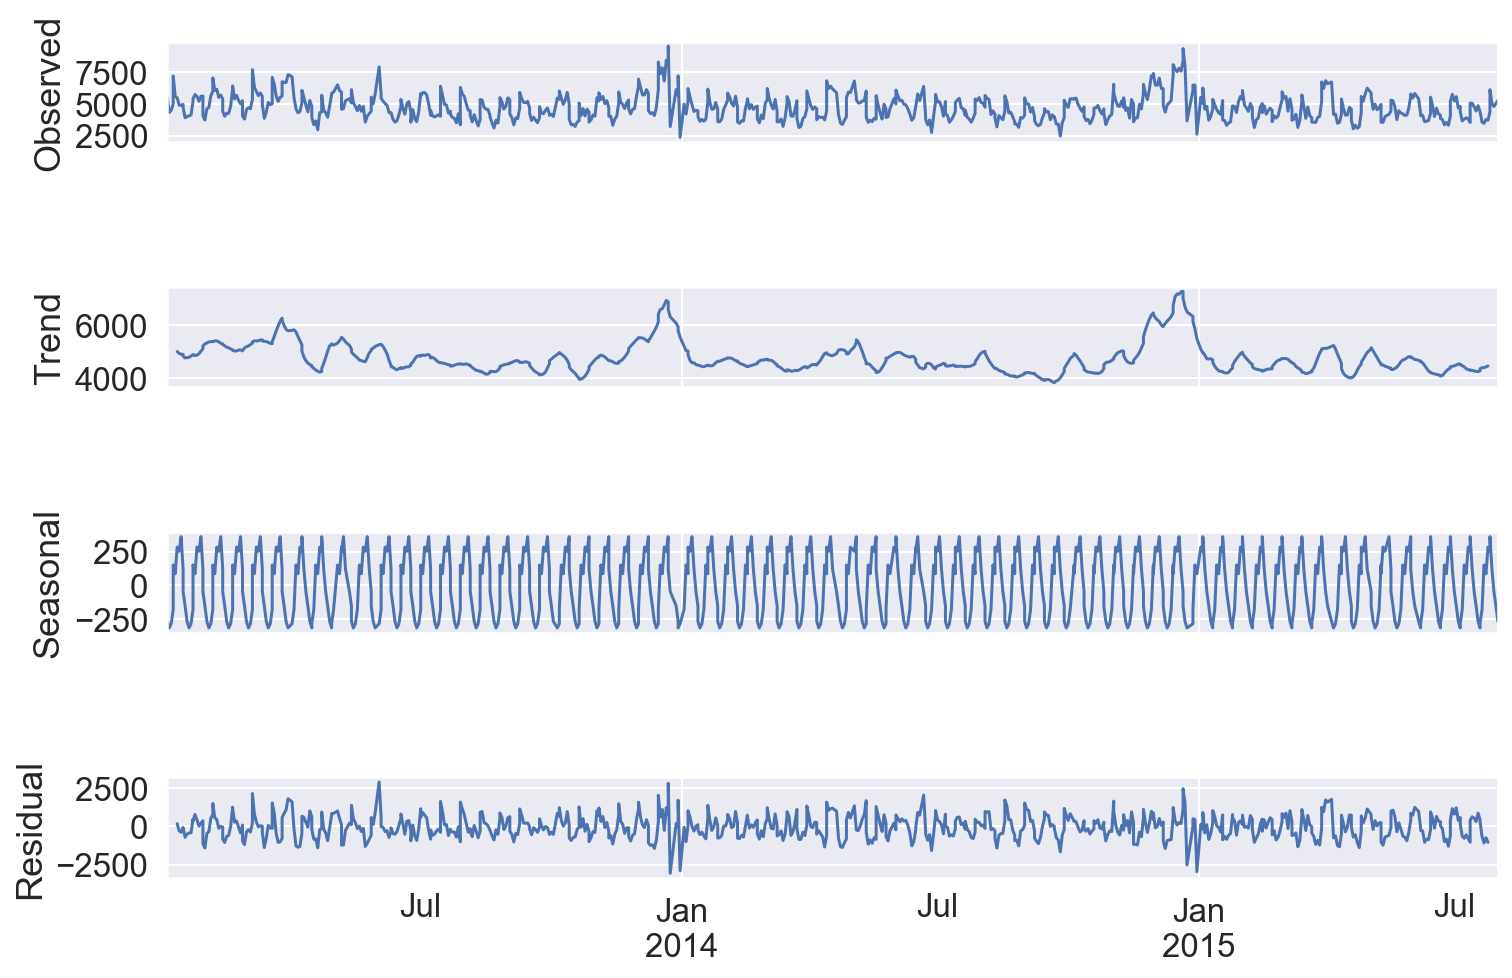

In [14]:
period = 12
decomposition = seasonal_decompose(data.Sales, freq=period)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## Plot the (partial) autocorrelations

In [15]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

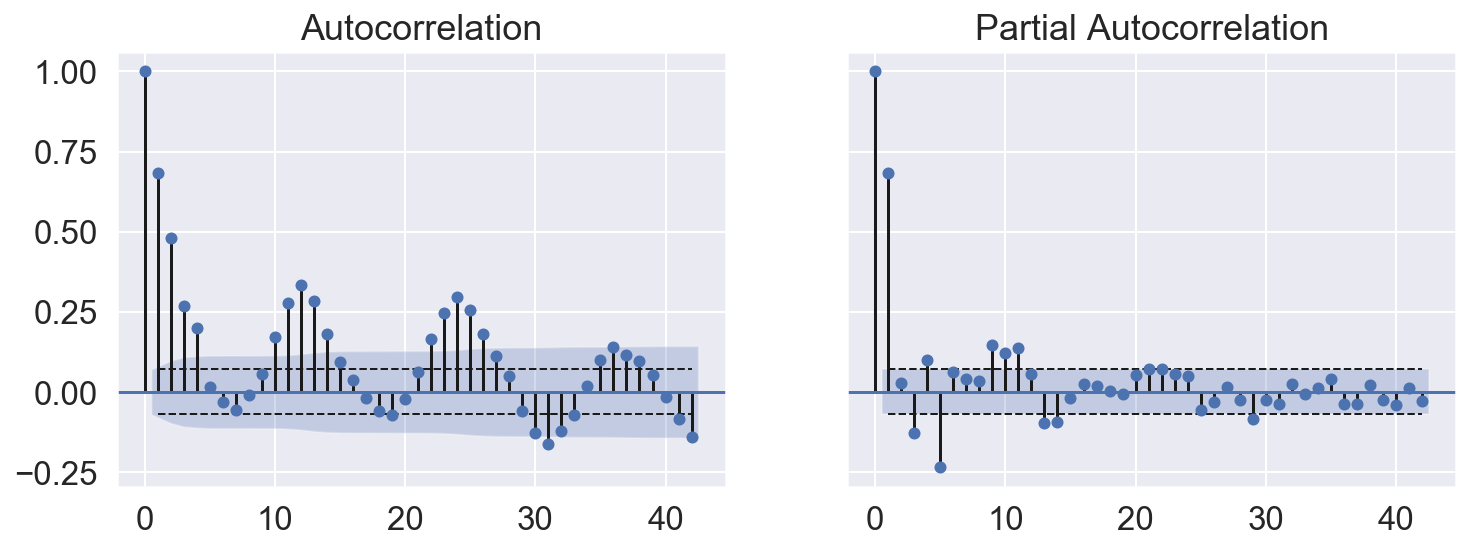

In [16]:
fig, ax = autocorr_plots(data.Sales, lags=42)

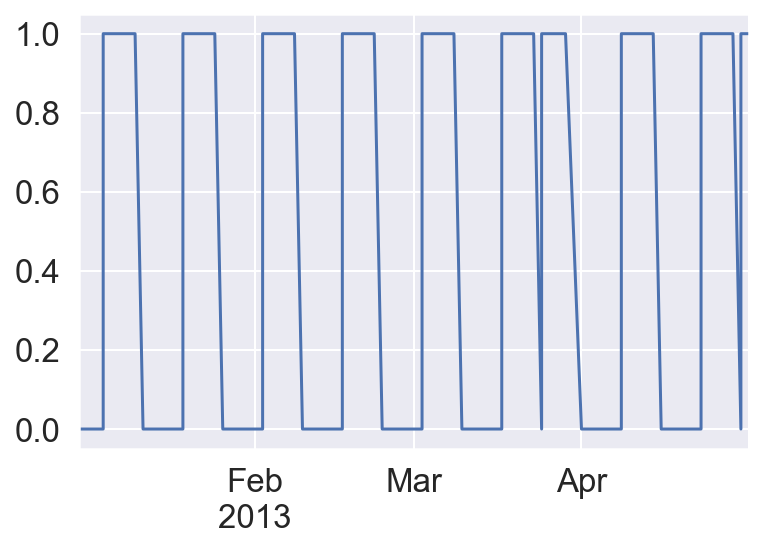

In [17]:
data.Promo[:100].plot()
plt.show()

## Test for the effect of ordinary and seasonal differencing

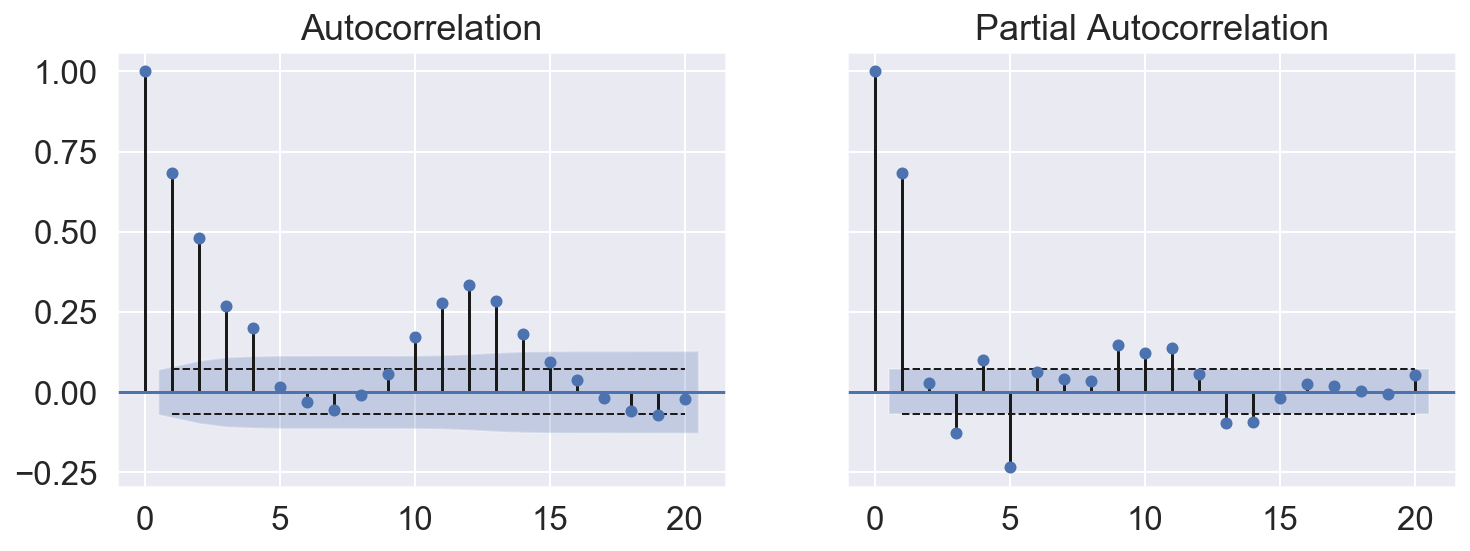

In [20]:
test_data = data.Sales
fig, ax = autocorr_plots(test_data)

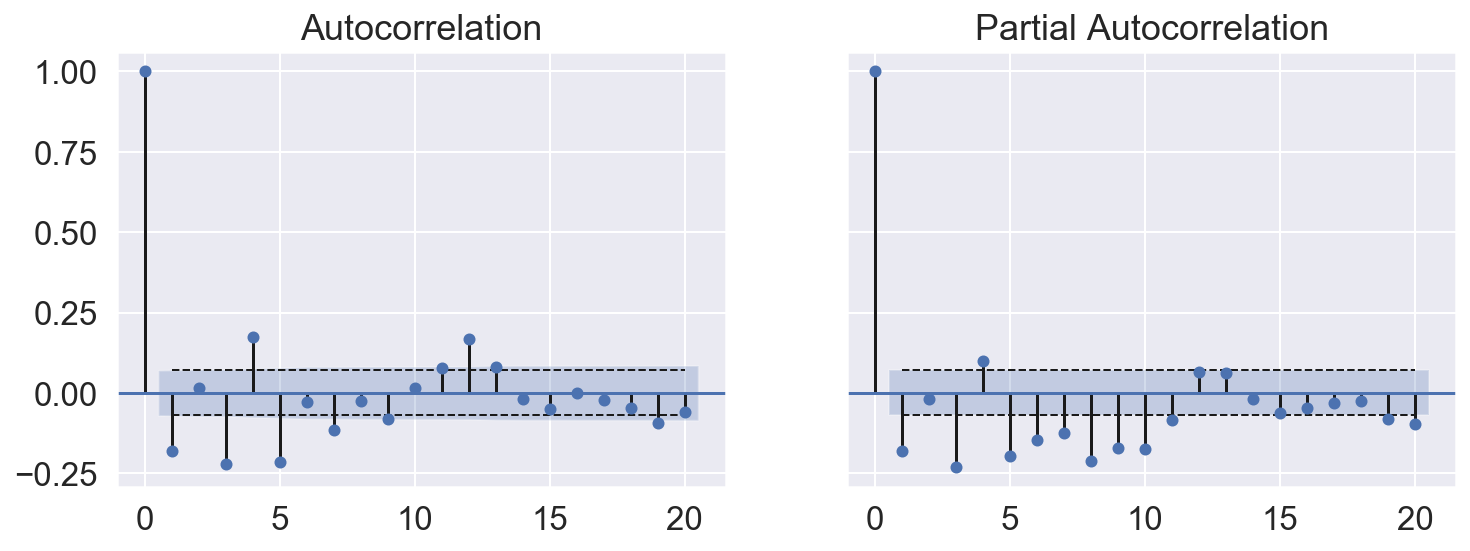

In [21]:
test_data = data.Sales.diff().dropna()
fig, ax = autocorr_plots(test_data)

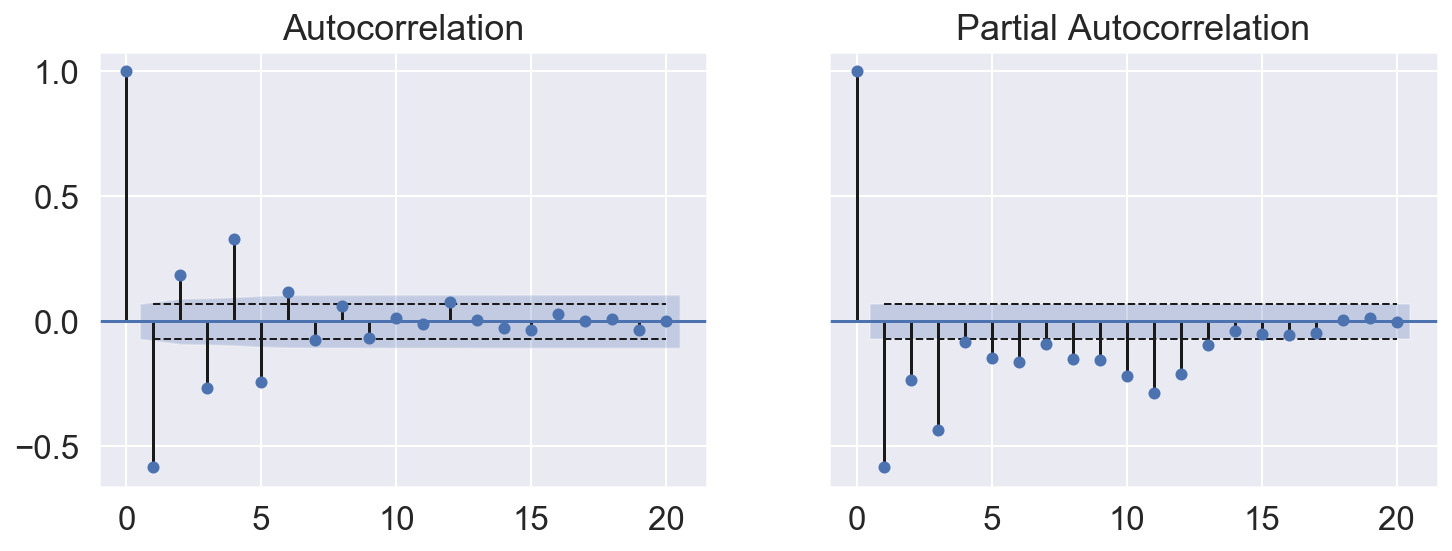

In [22]:
test_data = data.Sales.diff().diff().dropna()
fig, ax = autocorr_plots(test_data)

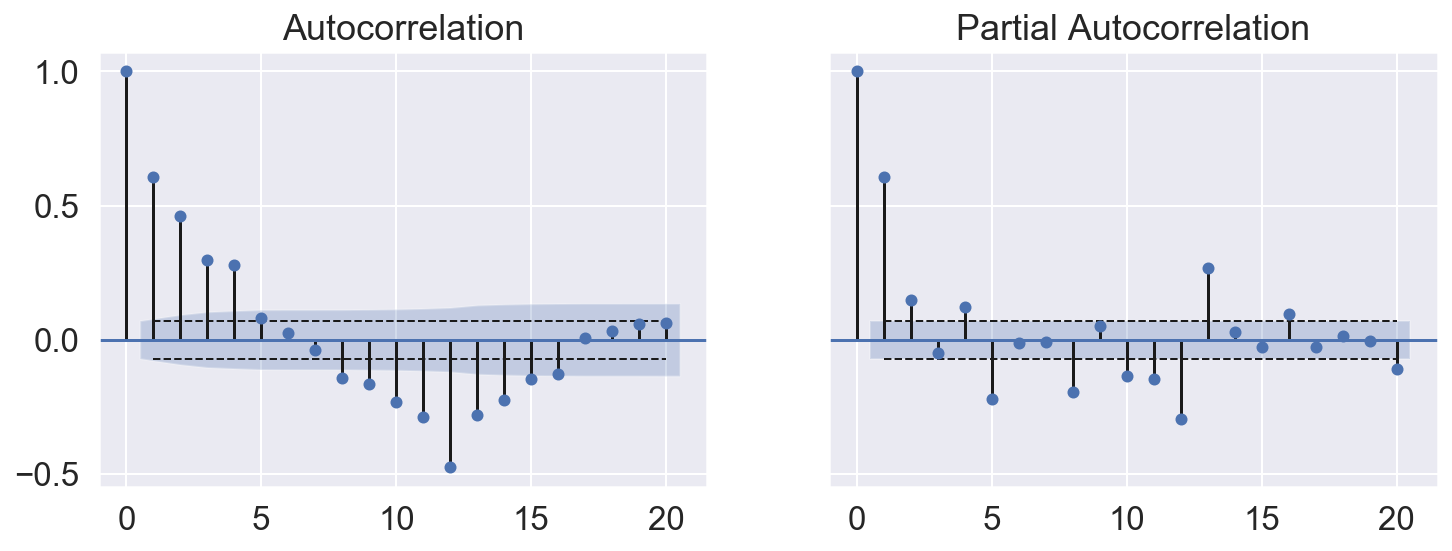

In [23]:
test_data = (data.Sales-data.Sales.shift(period)).dropna()
fig, ax = autocorr_plots(test_data)

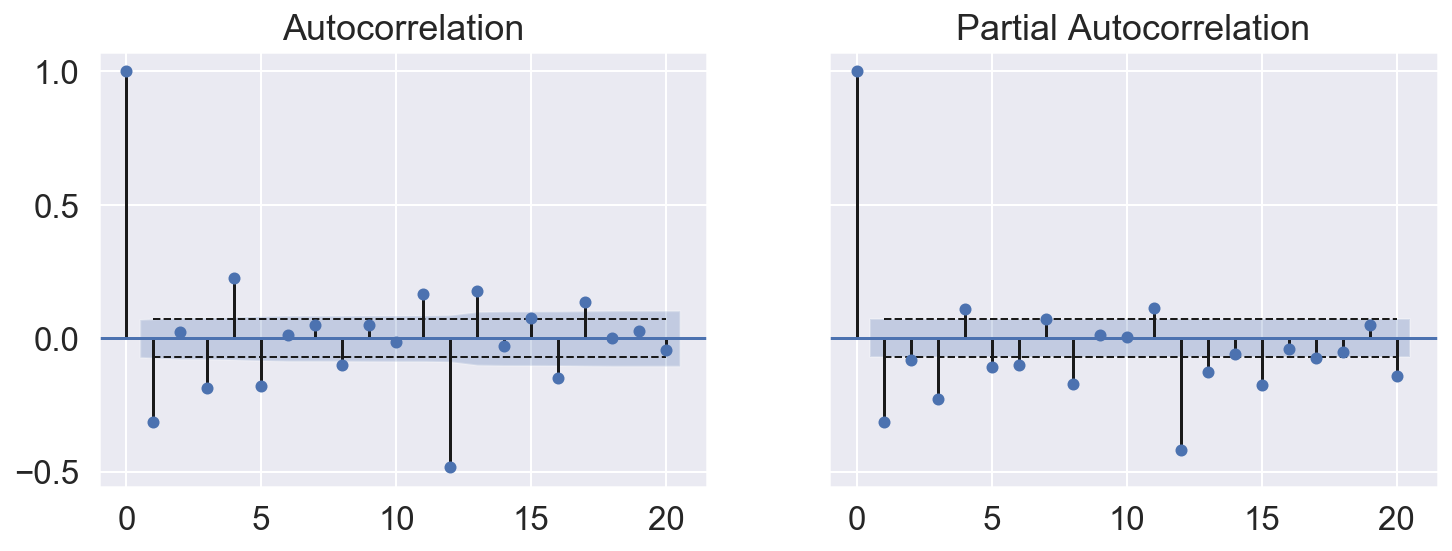

In [24]:
test_data = (data.Sales-data.Sales.shift(period)).diff().dropna()
fig, ax = autocorr_plots(test_data)

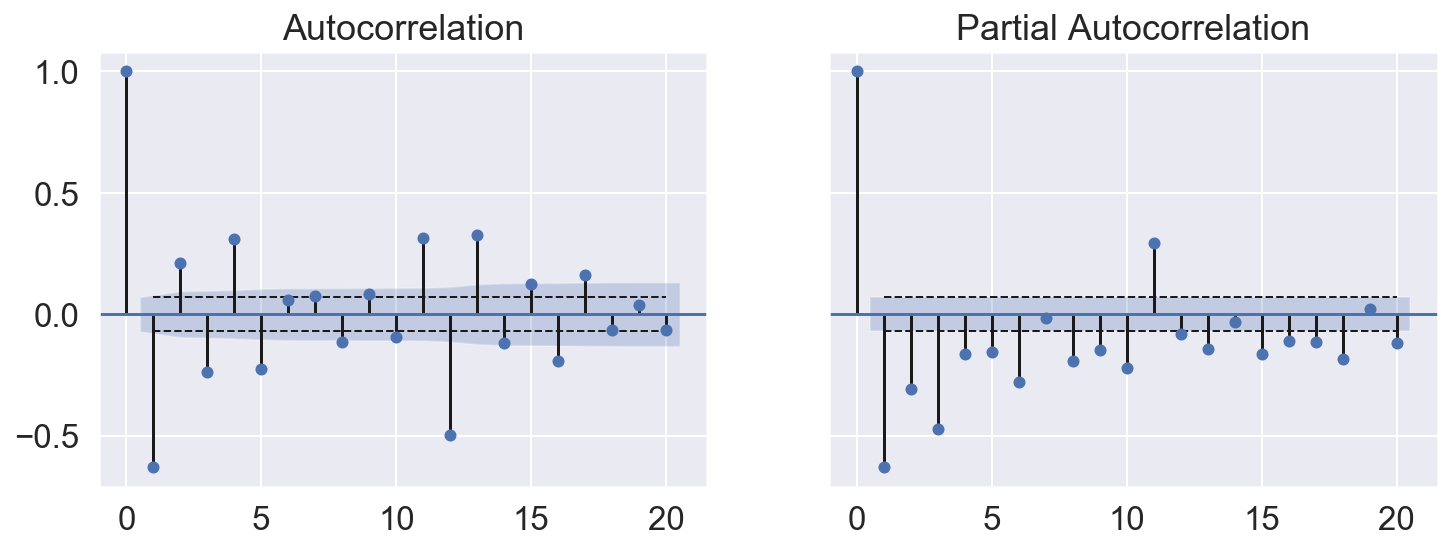

In [25]:
test_data = (data.Sales-data.Sales.shift(period)).diff().diff().dropna()
fig, ax = autocorr_plots(test_data)

## Fit a SARIMA model

- Fit and tune the model
- Provide plot diagnostics
- Produce in- and out-of-sample forecasts and plot
- Evaluate your model

In [26]:
model = sm.tsa.statespace.SARIMAX(data.Sales,
                                  order=(3, 1, 1),
                                  seasonal_order=(1, 0, 1, period))
results = model.fit(max_iter=1000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  781
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -6251.044
Date:                            Sat, 23 Nov 2019   AIC                          12516.087
Time:                                    16:49:33   BIC                          12548.702
Sample:                                01-02-2013   HQIC                         12528.632
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6672      0.100     -6.701      0.000      -0.862      -0.472
ar.L2         -0.2238      0.052     -4.289      0.000      -0.326      -0.122
ar.L3         -0.2706      0.035     -7.743      0.000      -0.339      -0.202
ma.L1          0.4283      0.103      4.154      0.000       0.226       0.630
ar.S.L12       0.8268      0.059     13.931      0.000       0.710       0.943
ma.S.L12      -0.6485      0.081     -7.984      0.000      -0.808      -0.489
sigma2      5.344e+05   1.58e+04     33.911      0.000    5.03e+05    5.65e+05
===================================================================================
Ljung-Box (Q):                      108.37   Jarque-Bera (JB):              1385.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.60
Prob(H) (two-sided):                  0.06   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

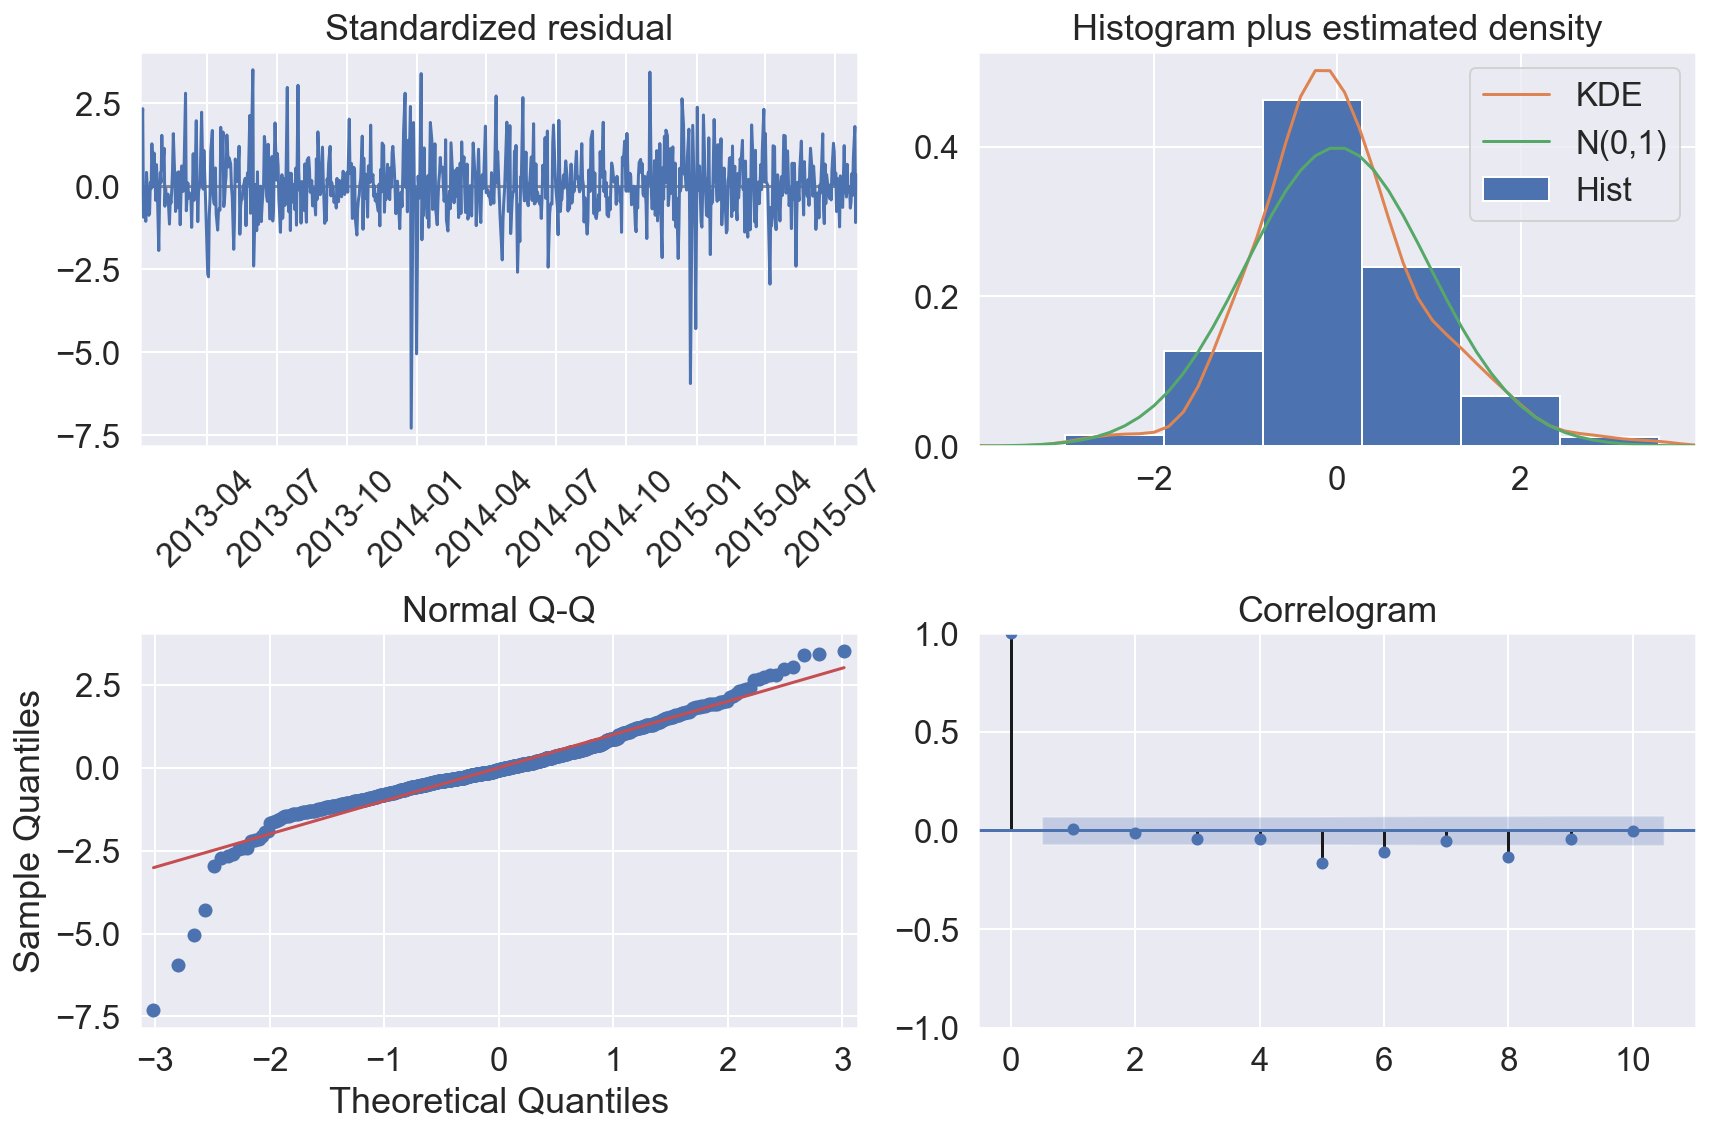

In [27]:
diag_plot = results.plot_diagnostics(figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

(781,) (600,) (781,)


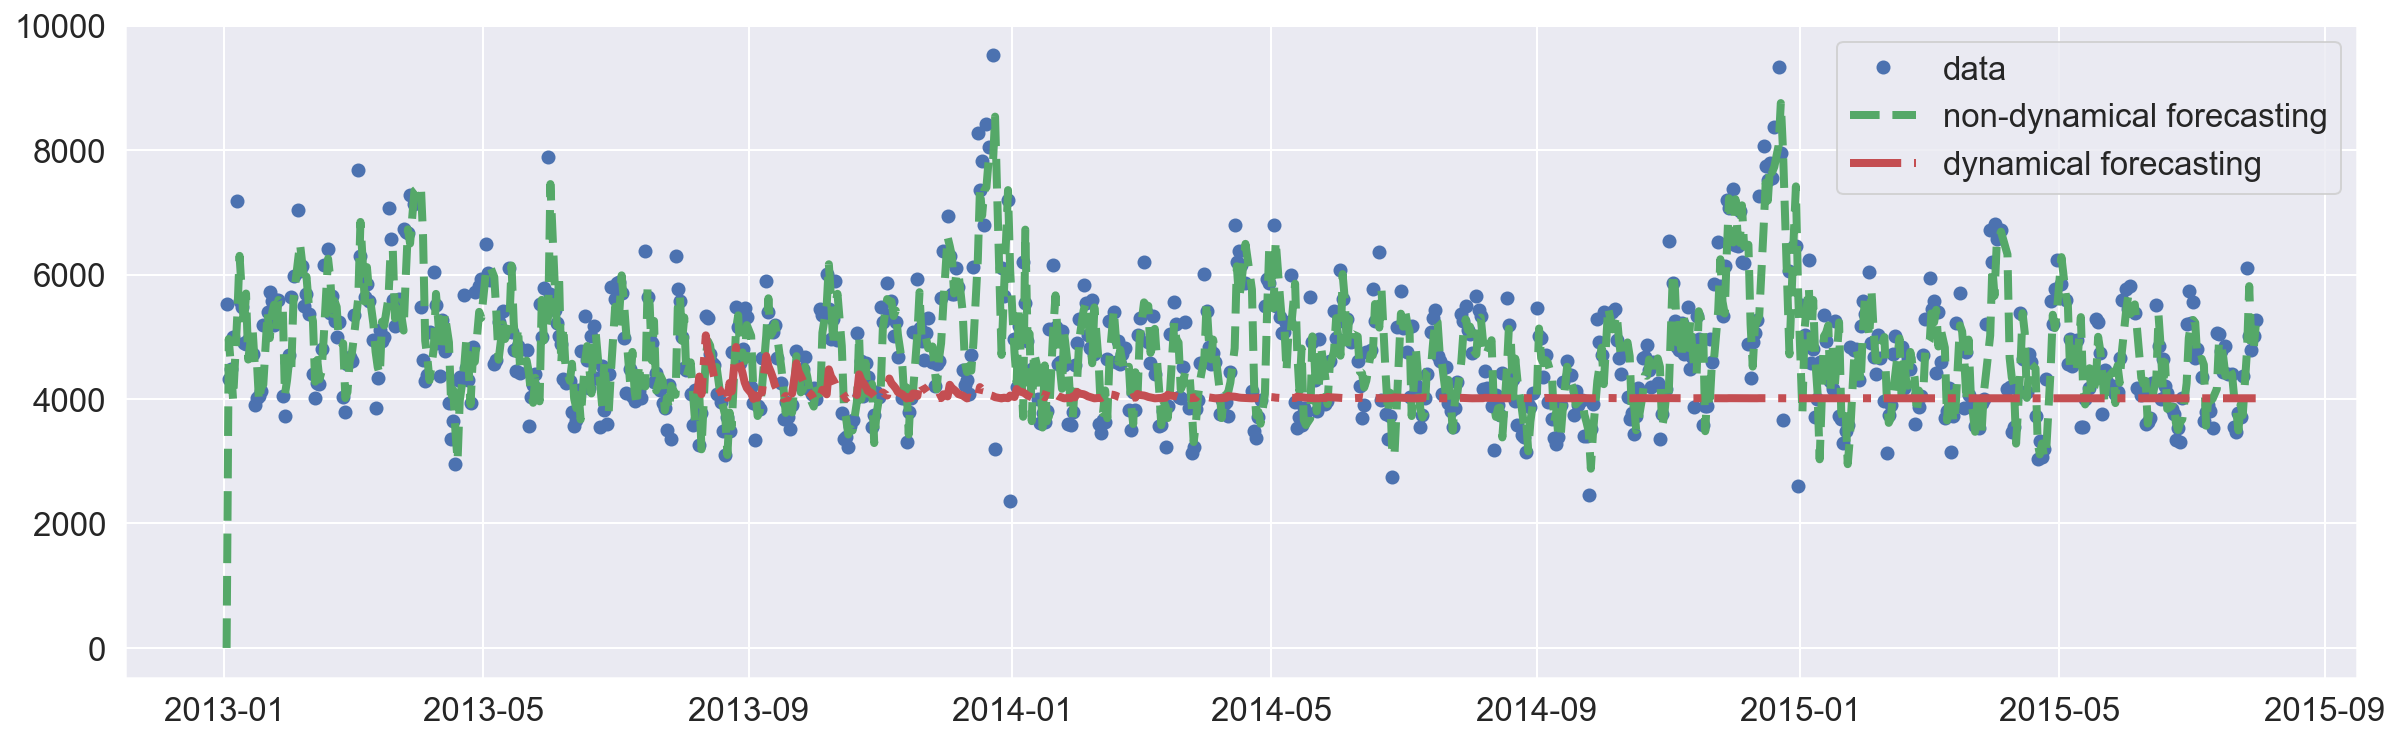

In [28]:
# forecasting
start_p = 600

# two equivalent ways for getting non-dynamical forecasts
# preds = results.forecast(50)
preds = results.predict(start=data.index.min(),
                        end=data.index.max(), dynamic=False)

preds_dyn = results.predict(start=data.index[len(
    data)-start_p], end=data.index.max(), dynamic=True)

fcast = pd.concat([data.Sales, preds])
fcast_1 = pd.concat([data.Sales[:len(data)-start_p], preds_dyn])

print(preds.shape, preds_dyn.shape, data.Sales.shape)

plt.figure(figsize=(20, 6))
plt.plot(data.Sales, 'bo', preds, 'g--', preds_dyn, 'r-.', lw=4)
plt.legend(['data', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()

In [29]:
print('MSE: ', results.params.sigma2)
print('R2: ', 1-results.params.sigma2/data.Sales.var())

MSE:  534359.7672143707
R2:  0.478347352732336


In [30]:
data.Sales.var()

1024359.3510226865

## Take exogeneous variables into account

In [31]:
data_1 = pd.get_dummies(
    data, columns=['DayOfWeek', 'StateHoliday'], drop_first=True)

In [32]:
data_1.columns

Index(['Store', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'StateHoliday_0'],
      dtype='object')

In [33]:
exog_columns = [col for col in data_1.columns if 'Day' in col] + \
    ['Promo', 'Customers']

In [34]:
exog_columns

['DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'Promo',
 'Customers']

In [35]:
model = sm.tsa.statespace.SARIMAX(data_1.Sales,
                                  exog=data_1[exog_columns],
                                  order=(3, 1, 1),
                                  seasonal_order=(1, 1, 0, period))
results = model.fit(maxiter=1000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  781
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -5470.285
Date:                            Sat, 23 Nov 2019   AIC                          10966.571
Time:                                    16:50:11   BIC                          11026.940
Sample:                                01-02-2013   HQIC                         10989.806
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
DayOfWeek_2   -78.2378     43.699     -1.790      0.073    -163.887       7.411
DayOfWeek_3  -211.1961     44.296     -4.768      0.000    -298.014    -124.378
DayOfWeek_4  -259.5191     43.019     -6.033      0.000    -343.835    -175.203
DayOfWeek_5  -217.0009     41.881     -5.181      0.000    -299.086    -134.915
DayOfWeek_6   -59.4482     44.154     -1.346      0.178    -145.989      27.093
Promo         485.7889     32.221     15.077      0.000     422.637     548.940
Customers       9.2406      0.143     64.714      0.000       8.961       9.520
ar.L1           0.1478      0.036      4.124      0.000       0.078       0.218
ar.L2           0.0579      0.036      1.592      0.111      -0.013       0.129
ar.L3           0.0256      0.036      0.717      0.473      -0.044       0.096
ma.L1          -1.0000      0.050    -19.802      0.000      -1.099      -0.901
ar.S.L12       -0.5042      0.030    -16.856      0.000      -0.563      -0.446
sigma2        8.87e+04      0.000    3.4e+08      0.000    8.87e+04    8.87e+04
===================================================================================
Ljung-Box (Q):                      146.79   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.87   Skew:                             0.15
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+25. Standard errors may be unstable.
"""

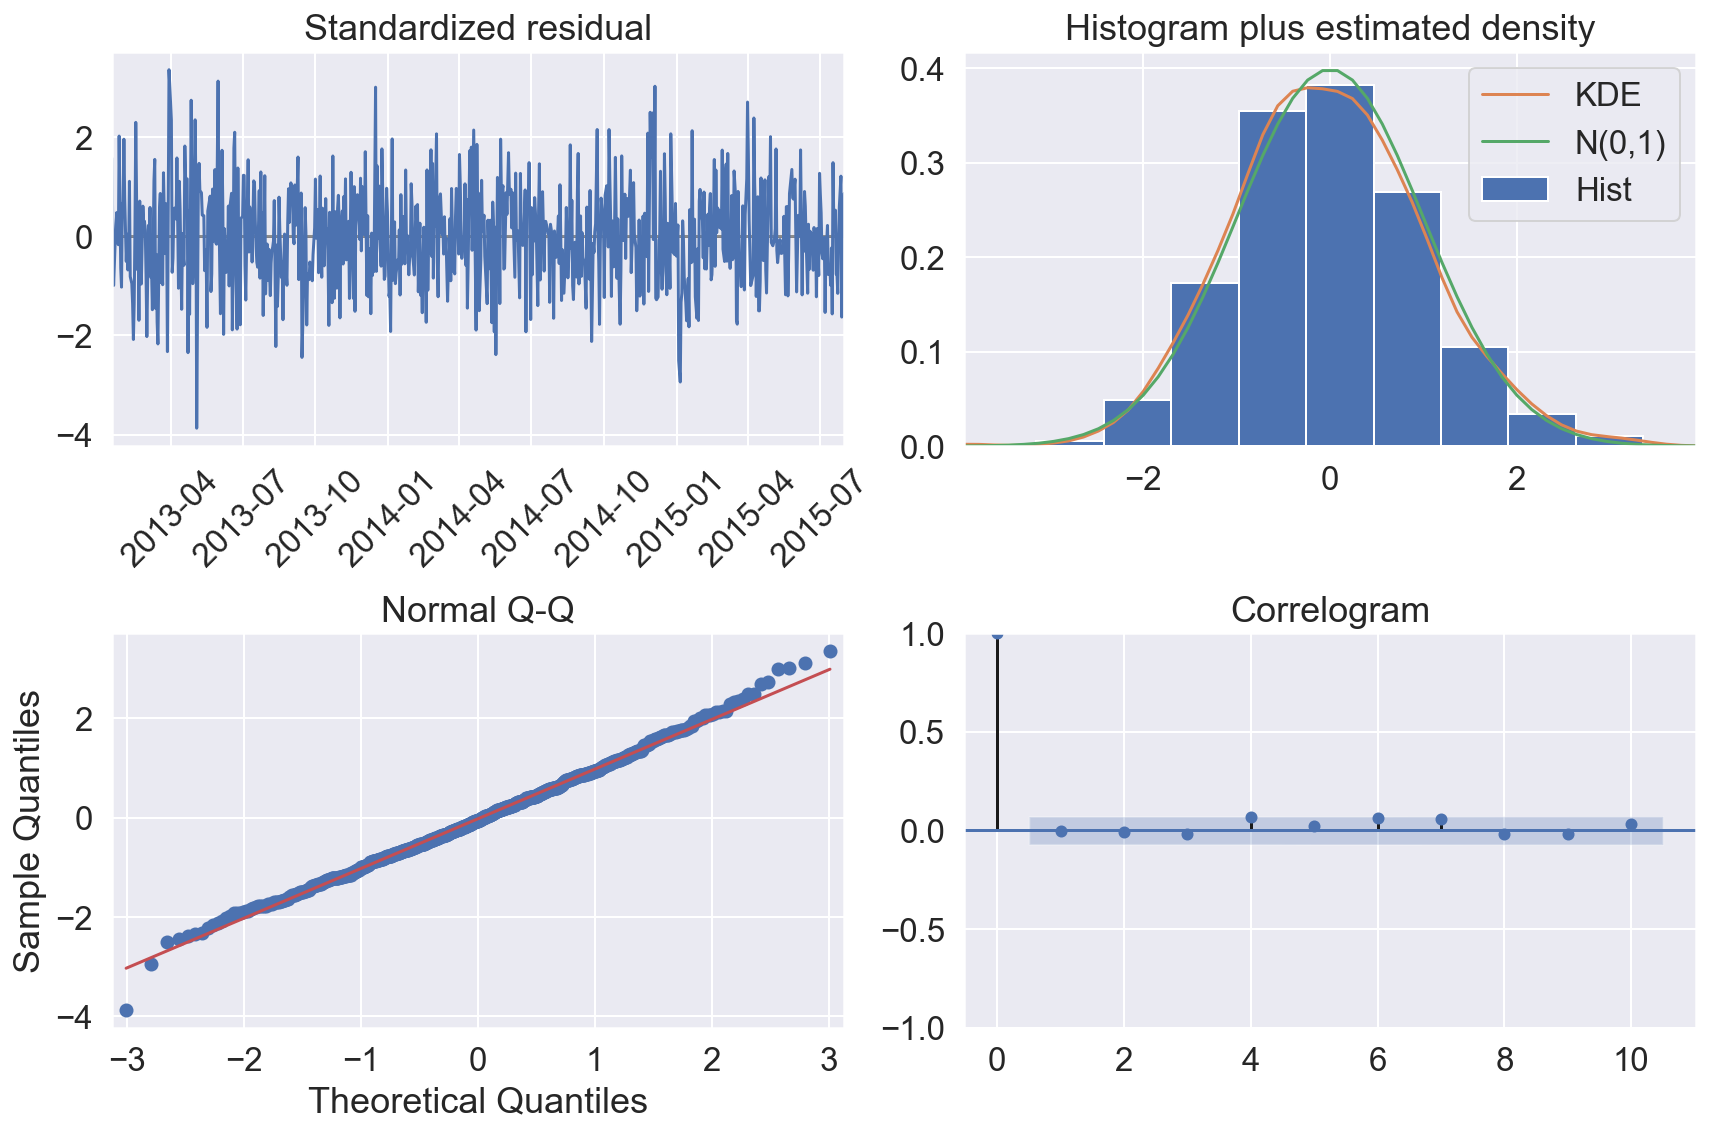

In [36]:
diag_plot = results.plot_diagnostics(figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

In [37]:
# complicated solution
# setup index for out-of-sample forecasts
forecast_end = 200
forecasts_index = pd.bdate_range(start=data_1.index[-1],
                                 periods=1+forecast_end,
                                 freq='C', weekmask=weekmask, holidays=holidays)


# choose exogenous predictors for forecasting (just pick one predictor row and keep it)
forecasts_exog = pd.DataFrame(data=np.repeat([data_1.loc[data_1.index.min(), exog_columns]], len(forecasts_index), axis=0),
                              index=forecasts_index,
                              columns=exog_columns)

forecasts = results.predict(
    start=data.index.max(),
    end=forecasts_index.max(),
    exog=forecasts_exog[1:])

In [38]:
forecasts_exog

,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Promo,Customers
2015-07-31,0,1,0,0,0,0,668
2015-08-01,0,1,0,0,0,0,668
2015-08-03,0,1,0,0,0,0,668
2015-08-04,0,1,0,0,0,0,668
2015-08-05,0,1,0,0,0,0,668
...,...,...,...,...,...,...,...
2016-03-16,0,1,0,0,0,0,668
2016-03-17,0,1,0,0,0,0,668
2016-03-18,0,1,0,0,0,0,668
2016-03-19,0,1,0,0,0,0,668


In [39]:
# simple solution
forecasts = results.predict(
    start=len(data_1)-1, 
    end=len(data_1)-1+forecast_end,
    dynamic=True,
    exog=forecasts_exog[1:])

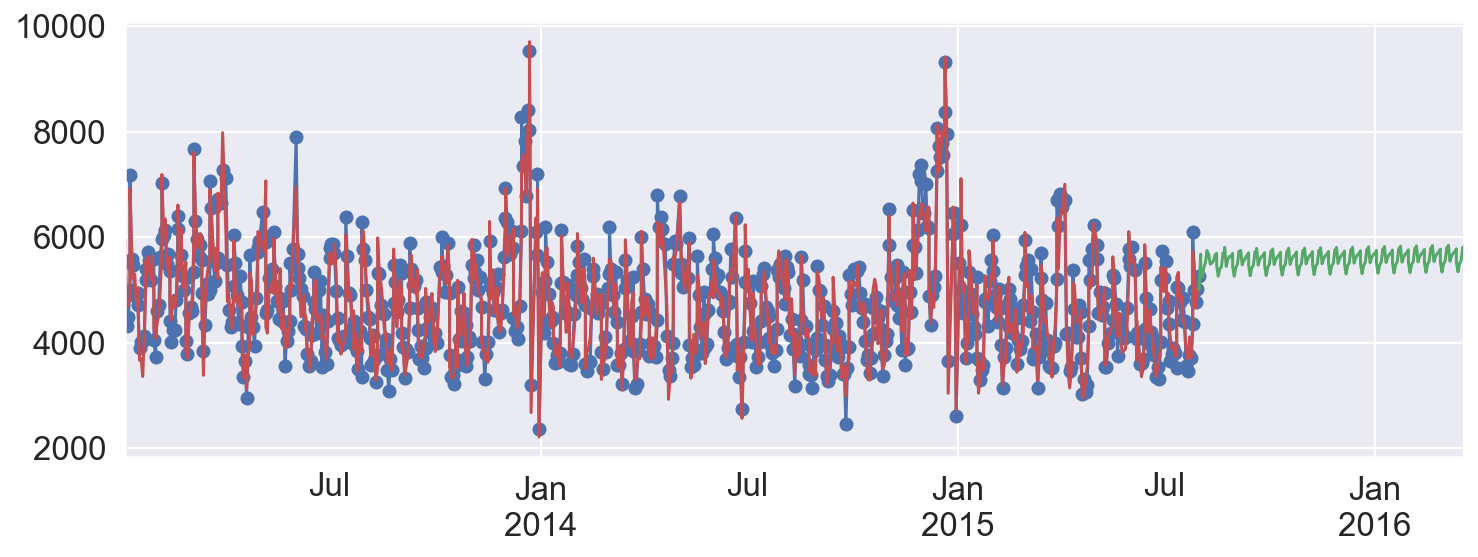

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
data_1.Sales.plot(marker='o', c='b', ax=ax)
results.predict(dynamic=False).plot(c='r', ax=ax)
forecasts.plot(c='g', ax=ax)

plt.show()

In [41]:
preds = results.predict(start=data_1.index.min(),
                        end=data_1.index.max(), dynamic=False)

In [42]:
print('MSE: ', results.params.sigma2)
print('R2: ', 1-results.params.sigma2/data_1.Sales.var())

MSE:  88699.11488278843
R2:  0.913410157486009


In [44]:
model = sm.tsa.statespace.SARIMAX(data_1.Sales,
                                  exog=data_1[exog_columns],
                                  order=(0, 0, 2),
                                  seasonal_order=(2, 0, 2, 12), trend='n')
results = model.fit(maxiter=1000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  781
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood               -5455.947
Date:                            Sat, 23 Nov 2019   AIC                          10939.894
Time:                                    16:50:54   BIC                          11005.142
Sample:                                01-02-2013   HQIC                         10964.988
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
DayOfWeek_2  -157.5262     29.828     -5.281      0.000    -215.988     -99.064
DayOfWeek_3  -246.9134     33.056     -7.470      0.000    -311.701    -182.125
DayOfWeek_4  -296.4398     36.255     -8.177      0.000    -367.498    -225.381
DayOfWeek_5  -219.8199     32.719     -6.718      0.000    -283.949    -155.691
DayOfWeek_6     8.2423     33.431      0.247      0.805     -57.281      73.766
Promo         547.9730     31.769     17.249      0.000     485.708     610.238
Customers       8.3060      0.050    166.499      0.000       8.208       8.404
ma.L1           0.2814      0.036      7.861      0.000       0.211       0.352
ma.L2           0.1795      0.033      5.523      0.000       0.116       0.243
ar.S.L12       -0.0280      0.380     -0.074      0.941      -0.773       0.718
ar.S.L24        0.5337      0.333      1.604      0.109      -0.118       1.186
ma.S.L12        0.1032      0.393      0.262      0.793      -0.668       0.874
ma.S.L24       -0.4302      0.329     -1.308      0.191      -1.075       0.214
sigma2       6.839e+04   3285.897     20.814      0.000     6.2e+04    7.48e+04
===================================================================================
Ljung-Box (Q):                       91.35   Jarque-Bera (JB):                20.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.30
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""